# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt

import numpy as np
import pickle

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
"""def unpickle(file):   
    with open(file, 'rb') as fo:       
        dict = pickle.load(fo, encoding='bytes')   
        return dict

def load_data(data_dir):
    #load train
    for i in range(1,6):
        filename = data_dir + f"data_batch_{i}" 
        dictionary  =unpickle(filename)
        x_data = dictionary[b"data"]
        y_data = np.array(dictionary[b"labels"])

        if == 1:
            x_train = x_data
            y_train = y_data
        else:
            x_train = np.concatenate((x_train, x_data), axis = 0)
            y_train = np.concatenate((y_train, y_data), axis = 0)

    #load test
    filename = data_dir + "test_batch"
    dictionary = unpickle(filename)
    data = dictionary[b"data"]
    x_test = data
    y_test = np.array(dictionary[b"labels"])
    return x_train, y_train, x_test, y_test
    """
# Define transforms
## YOUR CODE HERE ##
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# Create training set and define training dataloader
#https://www.datascienceweekly.org/tutorials/cifar10-pytorch-load-cifar10-dataset-from-torchvision
## YOUR CODE HERE ##
first_run = True

if first_run:
    download_flag = True
else:
    download_flag = False

#in the datasets library the ImageFolder module is already included
cifar_trainset = torchvision.datasets.CIFAR10(root = "./data/train", train=True, download=download_flag, transform=train_transform)

#split train data into train + val set
train_size = int(0.8 * len(cifar_trainset))
val_size = len(cifar_trainset) - train_size
train_dataset, val_dataset = random_split(
    dataset=cifar_trainset,
    lengths=[train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_set_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = False)

# Create test set and define test dataloader
## YOUR CODE HERE ##
cifar_testset = torchvision.datasets.CIFAR10(root = "./data/test", train=False, download=download_flag, transform=test_transform)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size = 64)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/train\cifar-10-python.tar.gz to ./data/train


100.0%


Extracting ./data/test\cifar-10-python.tar.gz to ./data/test


C:\Users\z635177\AppData\Local\Temp\ipykernel_23064\2176215597.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3618.)
  plt.imshow(image.squeeze().T, cmap="gray")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'frog')

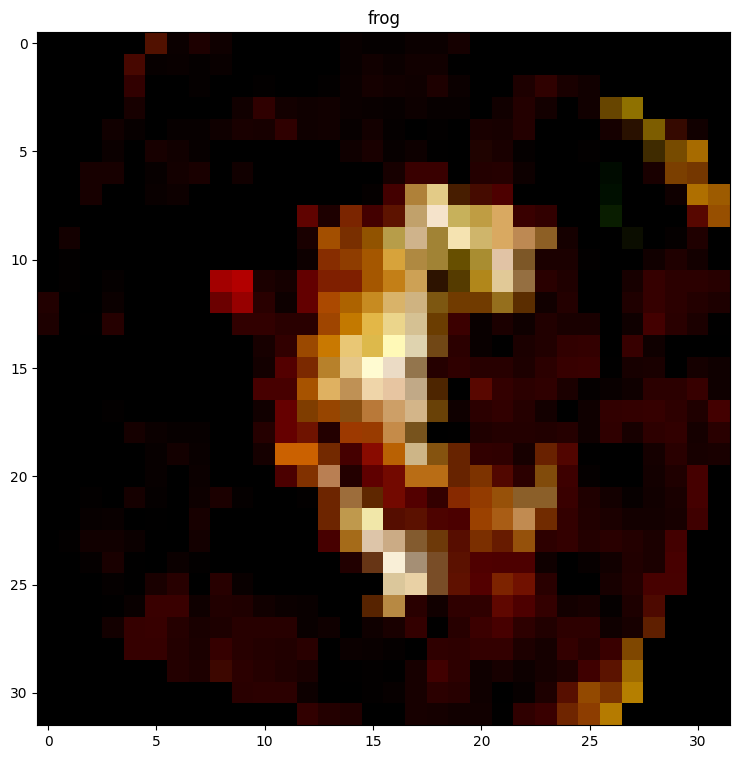

In [5]:
image, label = cifar_trainset[0]

fig = plt.figure(figsize = (9,9))
fig.add_subplot(1,1,1)
plt.imshow(image.squeeze().T, cmap="gray")
plt.title(f"{classes[label]}")

In [6]:
trainloader.dataset

In [7]:
testloader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [8]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


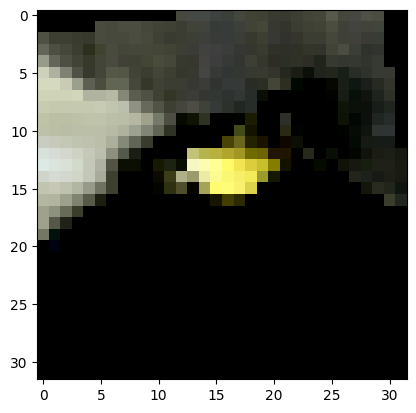

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


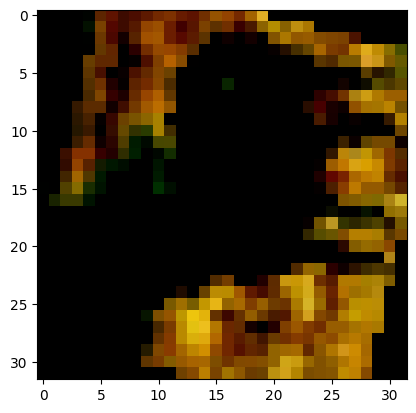

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


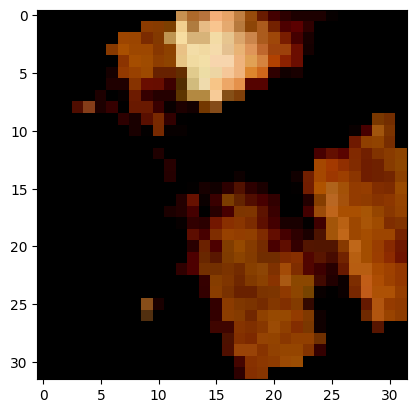

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


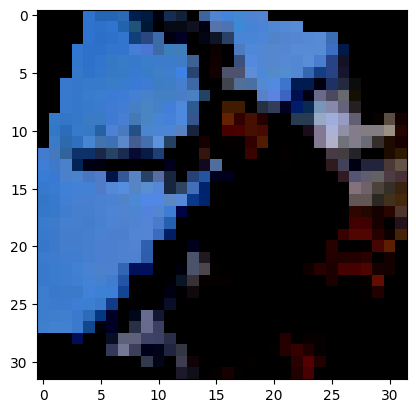

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


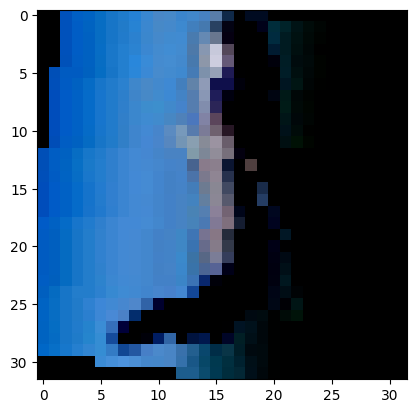

In [9]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [10]:
## YOUR CODE HERE ##
class neural_net(nn.Module):

    def __init__(self):

        super(neural_net, self).__init__()
        #conv mit output: (32-3+2x1)/1 +1 = 32
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1)
        #conv mit output: (32-3+2x1) / 1 + 1 = 32
        self.conv_2 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1,padding=1)
        self.fc1 = nn.Linear(24 * 8 * 8,60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):

        x = self.conv_1(x)                                       #32x32 = (32-3 + 2x1) / 1 + 1
        x = F.relu(x)
        x = F.max_pool2d(input=x, kernel_size=2, stride = 2)    #16x16 = (32-2)/2 + 1

        x = self.conv_2(x)                                       #16x16 = (16-3 + 2x1) / 1 + 1
        x = F.relu(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)            #8x8 = (16-2) / 2 + 1
        x = F.dropout(x, 0.2)             

        x = x.view(-1, 24 * 8 * 8)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x)        

In [11]:
next(iter(trainloader))[0].shape

torch.Size([64, 3, 32, 32])

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [21]:
## YOUR CODE HERE ##

model = neural_net()
model.cuda()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [22]:
## YOUR CODE HERE ##
epochs = 100
steps = 0

train_losses, val_losses = [], []

for epoch in range(epochs):

    running_loss = 0
    model.train()

    for batch_id, (data, target) in enumerate(trainloader):
        #Training
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        y_pred_train = model.forward(data)
    
        loss = criterion(y_pred_train, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        val_loss = 0
        accuracy = 0

        with torch.no_grad():
            model.eval()
            for batch_id, (data, target) in enumerate(val_set_loader):
                #forward pass
                data = data.cuda()
                target = target.cuda()

                y_pred_val = model.forward(data)
                val_loss += criterion(y_pred_val, target).item()

                y_pred_val = torch.exp(y_pred_val)
                top_p, top_class = y_pred_val.topk(1, dim=1)
                equals = top_class == target.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss / len(trainloader))
        val_losses.append(val_loss / len(val_set_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
            "Val Loss: {:.3f}.. ".format(val_loss/len(val_set_loader)),
            "Val Accuracy: {:.3f}".format(accuracy/len(val_set_loader)))

C:\Users\z635177\AppData\Local\Temp\ipykernel_23064\3601851005.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 1/100..  Training Loss: 2.205..  Val Loss: 2.037..  Val Accuracy: 0.274
Epoch: 2/100..  Training Loss: 1.944..  Val Loss: 1.871..  Val Accuracy: 0.333
Epoch: 3/100..  Training Loss: 1.822..  Val Loss: 1.762..  Val Accuracy: 0.376
Epoch: 4/100..  Training Loss: 1.711..  Val Loss: 1.641..  Val Accuracy: 0.410
Epoch: 5/100..  Training Loss: 1.616..  Val Loss: 1.584..  Val Accuracy: 0.429
Epoch: 6/100..  Training Loss: 1.555..  Val Loss: 1.520..  Val Accuracy: 0.457
Epoch: 7/100..  Training Loss: 1.513..  Val Loss: 1.491..  Val Accuracy: 0.457
Epoch: 8/100..  Training Loss: 1.478..  Val Loss: 1.454..  Val Accuracy: 0.479
Epoch: 9/100..  Training Loss: 1.446..  Val Loss: 1.420..  Val Accuracy: 0.497
Epoch: 10/100..  Training Loss: 1.415..  Val Loss: 1.389..  Val Accuracy: 0.504
Epoch: 11/100..  Training Loss: 1.392..  Val Loss: 1.377..  Val Accuracy: 0.497
Epoch: 12/100..  Training Loss: 1.371..  Val Loss: 1.356..  Val Accuracy: 0.515
Epoch: 13/100..  Training Loss: 1.349..  Val Loss

Plot the training loss (and validation loss/accuracy, if recorded).

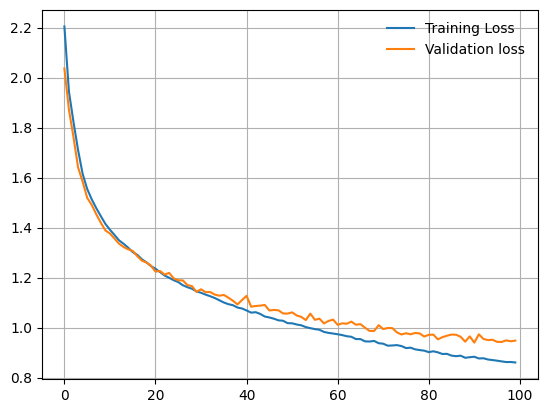

In [23]:
## YOUR CODE HERE ##
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation loss")
plt.legend(frameon=False)
plt.grid();

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [24]:
## YOUR CODE HERE ##
test_losses_final = []
accuracy = 0
test_loss = 0

with torch.no_grad():
    model.eval()
    for batch_id, (data, target) in enumerate(testloader):
        #forward pass
        data = data.cuda()
        target = target.cuda()

        y_pred_test = model.forward(data)
        test_loss += criterion(y_pred_test, target).item()

        y_pred_test = torch.exp(y_pred_test)
        top_p, top_class = y_pred_test.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

C:\Users\z635177\AppData\Local\Temp\ipykernel_23064\3601851005.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [25]:
accuracy.item() / len(testloader)

0.6998407643312102

## Saving your model
Using `torch.save`, save your model for future loading.

In [26]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), "checkpoint.pth")

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

As stated in the introduction, the company Detectocorp's algorithm is reaching a 70% accuracy rate on the CIFAR-10 dataset. <br>
The task was to investigate if it's possible to create an inhouse algorithm performing at least as well as this algorithm provided from Detectocorp.<br>

Within this buy or make analysis, we developed a CNN Classifier trained on the CIFAR-10 Dataset and as a result we reached an accuracy rate of around 69 %. It should be noticed that this development has been a simple proof of concept to challenge the algorithm of Detectocorp to support the  "Build or Buy decision". <br>

In summary, with a quite effortless setup we could reach a performance of around 69 % and we are confident to either fine-tune the architecture of the proof of concept CNN or the hyperparameter of the model to beat the performance of Detectocorp.<br>
<br>
So, we advise to build the algorithm ourselves.